In [1]:
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import re
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer, TrainingArguments
from trl import SFTTrainer, SFTConfig
import torch
from peft import LoraConfig, get_peft_model
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from statistics import mean
from tqdm import tqdm

/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = 'mistralai/Mistral-7B-Instruct-v0.3'

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
#tokenizer.add_special_tokens({'additional_special_tokens':['<INFORMATION>','</INFORMATION>','<PERCEPTION>', '</PERCEPTION>', '<BACKGROUND>', '</BACKGROUND>']})

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_storage=torch.bfloat16,
# )

# LMmodel = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config = bnb_config,
#     torch_dtype = torch.bfloat16,
#     device_map = 'auto'
# )
# LMmodel.resize_token_embeddings(len(tokenizer))

# peft_config = LoraConfig(target_modules=[ "v_proj", "q_proj", "up_proj", "o_proj", "k_proj", "down_proj", "gate_proj" ], inference_mode=False, r=4, lora_alpha=32, lora_dropout=0.1)

# LMmodel = get_peft_model(LMmodel, peft_config)

# LMmodel.print_trainable_parameters()

In [2]:
# load data
cce_df = pd.read_csv("../data/finecite/full_data.csv")

In [4]:
#clean data
def label_mapping(label):
    if type(label) == int:
        if label == 1: return 'INFORMATION'
        if label == 2: return 'PERCEPTION'
        if label == 3: return 'BACKGROUND'
    else:
        if label == 'INFORMATION': return 1
        if label == 'PERCEPTION': return 2
        if label == 'BACKGROUND': return 3
    
def replace_ref(word):
    if re.match(r'single', word):
        return '[REF]'
    else:
        return '[REF]'


# Process the DataFrame
results = []
for index, row in cce_df.iterrows():
    
    #clean all ';' from references
    clean_paragraph = re.sub(r'<ref.*?>.*?</ref>',lambda x: x.group().replace(';',','), row['paragraph'])
    
    #create word list of par
    words_par = clean_paragraph.split(';')
    
    #replace (G)TREF
    words_par[row['target_reference_location']] = '[TREF]' #if re.search(r'single', words_par[row['target_reference_location']]) else '[GTREF]'
    
    # Clean the paragraph by replacing <ref> tags with '[TREF]'
    words_par = [replace_ref(word) if re.search(r'<ref.*?>.*?</ref>', word) else word for word in words_par]
    

    # Process the context_location1 list
    context_location1 = eval(row["context_location1"])

    # check whether context label and word list are same length
    assert len(context_location1) == len(words_par), f'The labels are of length {len(context_location1)}, while the word list is of length {len(words_par)}'
    
    # Aggregate the mapped results for the current row
    mapped_result = list(zip(context_location1, words_par))
    
    # tokenize string to evaluate token length
    tokenized_string = tokenizer.tokenize(' '.join(words_par))
    
    
    max_len = 300
    if len(tokenized_string) > max_len:
        word_tokens = []
        labels = []
        word_id = []
        for idx, (label, word) in enumerate(mapped_result):
            tokens = tokenizer.tokenize(word)
            word_tokens.extend(tokens)
            labels.extend([labels] * len(tokens))
            word_id.extend([idx] * len(tokens))
        assert len(word_tokens) == len(labels), 'something went wrong in the tokenization process'
        
        excess_len = len(word_tokens) - max_len
        zero_count_start = labels[:excess_len].count(0)
        zero_count_end = labels[max_len:].count(0)
        if zero_count_end > zero_count_start:
            end_id = word_id[max_len]
            mapped_result = list(zip(context_location1[:end_id -1], words_par[:end_id -1]))
        else:
            begin_id = word_id[excess_len-1]
            mapped_result = list(zip(context_location1[begin_id +1:], words_par[begin_id +1:]))
    
    
    
    # Separate the numbers and words into separate lists
    numbers = [item[0] for item in mapped_result]  # Convert numbers to strings
    mapped_words = [item[1].strip() for item in mapped_result]  # Strip extra spaces from words
    
    # skip entry if target reference is not present
    if '[GTREF]' not in mapped_words and '[TREF]' not in mapped_words: continue

    sem_structured_context = []
    prev_label = 0
    for label, word in mapped_result:
        if label != prev_label:
            if prev_label != 0:
                sem_structured_context.append(f'</{label_mapping(prev_label)}>')
            if label != 0:
                sem_structured_context.append(f'<{label_mapping(label)}>')
        sem_structured_context.append(word)
        prev_label = label
    if prev_label != 0:
        sem_structured_context.append(f'</{label_mapping(prev_label)}>')      
        
    
    
    results.append({
        "Paragraph": ' '.join(mapped_words),
        "Scope": numbers,
        "labels": ' '.join(sem_structured_context)
    })

# Convert results to DataFrame
df = pd.DataFrame(results)
df

,Paragraph,Scope,labels
0,Neural Machine Translation (NMT) has opened se...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",<BACKGROUND> Neural Machine Translation (NMT) ...
1,"As shown in Table 1, the size of the 'in-domai...","[0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","As shown in Table 1, <BACKGROUND> the size of ..."
2,Automatic extraction of events has gained siza...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",<PERCEPTION> Automatic extraction of events ha...
3,The subject NP 'Bill' is coindexed with the tr...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",<BACKGROUND> The subject NP 'Bill' is coindexe...
4,Self-training [TREF] ) uses a source-to-target...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",<INFORMATION> Self-training [TREF] ) uses a so...
...,...,...,...
1019,Taking inspiration from gradient checkpointing...,"[2, 2, 2, 1, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, ...",<PERCEPTION> Taking inspiration from </PERCEPT...
1020,• RNN-NLU [TREF] ) is an attention-based bi-di...,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",• <INFORMATION> RNN-NLU [TREF] ) is an attenti...
1021,"For the final-stage neural reranker, we experi...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, ...","For the final-stage neural reranker, we experi..."
1022,Trained on 20GB texts of both Vietnamese news ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Trained on 20GB texts of both Vietnamese news ...


<Axes: ylabel='Count'>

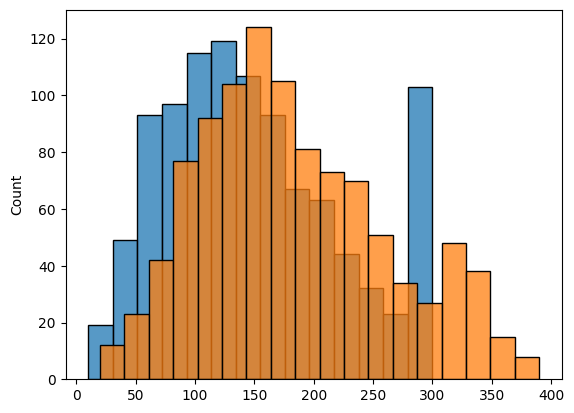

In [5]:
#check input and output token length
length_par = []
length_labels = []
for idx, row in df.iterrows():
    length_par.append(len(tokenizer.tokenize(row['Paragraph'])))
    
    length_labels.append(len(tokenizer.tokenize(row['labels'])))
    
import seaborn as sns
sns.histplot(data=length_par)
sns.histplot(data=length_labels)

In [6]:
def get_fine_tune_prompt_xml( 
    input_str: str,
    label_str: str,
    tokenizer,
    test: bool = False
) -> torch.Tensor:

    usr_msg1 = "You are given a excerpt from a scientific text with citations that are marked as [REF] or[TREF], and a list of context types" \
        "Your task is it to find the citation context of the targeted citation marked by [TREF]" \
        "To do this first find the targeted citation, "\
        "second, identify which part of the excerpt belongs to one of the context types, "\
        "third, annotate the context by adding XML tags (e.g. <INFORMATION> ... </INFORMATION>) to the input "\
        "Context types can occure multiple times. Some parts of the input might not belong to any context"\
        "Format all XML tags correctly, do not change the wording, do not exceed the input, do return anythig else that the input with added annotation" \
        f"""\n\nList Context Types\n
        INFORMATION: includes the information that are cited from the cited article \n
        PERCEPTION: perception or use of the cited information in the citing paper \n
        BACKGROUND: backgound or further information on why the citation is included \n
        """\
        "\n\n" \
        "Are the instructions clear to you?"
    
    asst_msg1 = "Yes, the instructions are clear to me."\
                "I will correctly identify the context of the as targeted marked citation ([TREF]) by adding the correct XML tags to the input. I will return anythig else that the input with added annotation"
    
    usr_msg2 = "Table 5: The experimental results of passage reading on NQ dataset. In this paper, we focus on extractive reader, while the recent generative readers [TREF] can also be applied here and may lead to better results."

    asst_msg2 = "Table 5: The experimental results of passage reading on NQ dataset. <BACKBROUND> In this paper, we focus on extractive reader, while </BACKBROUND><INFORMATION> the recent generative readers [TREF] </INFORMATION><PERCEPTION> can also be applied here and may lead to better results.</PERCEPTION>"

    usr_msg3 = "Give a brief explanation of why your answer is correct."

    asst_msg3 = "The provided text discusses the advantages and limitations of massive multilingual NMT models." \
                "The context type 'BACKGROUND' is used to explain the purpose of these models, which is to exploit as many and diverse data as possible."\
                "The context type 'INFORMATION' is used to provide specific details about the massive multilingual NMT models, such as the fact that they take advantage of several language-pair datasets in a single system."\
                "The reference marker [TREF] is used to cite the source of this information. The context type 'PERCEPTION' is not used in this text, as it refers to the perception or use of the cited content, and in this case, there is no explicit mention of how the information is being used or perceived"
    
    usr_msg4 = "Great! I am now going to give you another user utterance. Please detect the context types in it " \
                "according to the previous instructions. Do not include an explanation in your answer."
    
    asst_msg4 = "Sure! Please give me the user utterance."

    messages = [
        {"role": "user", "content": usr_msg1},
        {"role": "assistant", "content": asst_msg1},
        {"role": "user", "content": usr_msg2},
        {"role": "assistant", "content": asst_msg2},
        # {"role": "user", "content": usr_msg3},
        # {"role": "assistant", "content": asst_msg3},
        # {"role": "user", "content": usr_msg4},
        # {"role": "assistant", "content": asst_msg4},
        {"role": "user", "content": input_str},
    ]
    if not test: messages.append({"role": "assistant", "content": label_str})
    
    encoded_input_ids = tokenizer.apply_chat_template(messages)

    return {'input_ids': encoded_input_ids}

In [7]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union

@dataclass
class CustomDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        labels = batch["input_ids"].clone()
        
        # # Set loss mask for all pad tokens
        # labels[labels == self.tokenizer.pad_token_id] = -100
        
        # Compute loss mask for appropriate tokens only
        for i in range(batch['input_ids'].shape[0]):
            
            # Decode the training input
            text_content = self.tokenizer.decode(batch['input_ids'][i][1:])  # slicing from [1:] is important because tokenizer adds bos token
            
            # Extract substrings for prompt text in the training input
            # The training input ends at the last user msg ending in [/INST]
            prompt_gen_boundary = text_content.rfind("[/INST]") + len("[/INST]")
            prompt_text = text_content[:prompt_gen_boundary]
            
            # print(f"""PROMPT TEXT:\n{prompt_text}""")
            
            # retokenize the prompt text only
            prompt_text_tokenized = self.tokenizer(
                prompt_text,
                return_overflowing_tokens=False,
                return_length=False,
            )
            # compute index where prompt text ends in the training input
            prompt_tok_idx = len(prompt_text_tokenized['input_ids'])
            
            # Set loss mask for all tokens in prompt text
            labels[i][range(prompt_tok_idx)] = -100
            
                    
        batch["labels"] = labels
        return batch

In [8]:
# split data in train / test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=96, shuffle=True)
test_df.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)

# Convert the DataFrame to a Dataset
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df[:9])

#Apply the tokenization function to the dataset
train_ds = train_ds.map(
    lambda row: get_fine_tune_prompt_xml(row['Paragraph'], row['labels'], tokenizer), 
    batched=False, 
    remove_columns=train_ds.column_names  # Remove all original columns
)

test_ds = test_ds.map(
    lambda row: get_fine_tune_prompt_xml(row['Paragraph'], row['labels'], tokenizer, True), 
    batched=False, 
    remove_columns=test_ds.column_names  # Remove all original columns
)

Map: 100%|██████████| 9/9 [00:00<00:00, 1216.48 examples/s]


<Axes: ylabel='Count'>

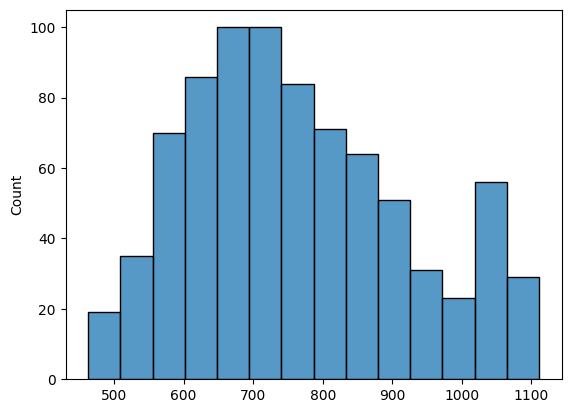

In [9]:
length = []
for item in train_ds:
    length.append(len(item['input_ids']))
sns.histplot(data=length)

In [17]:
max_seq_length = 1024

data_collator=CustomDataCollatorWithPadding(
    tokenizer=tokenizer, 
    padding="longest", 
    max_length=max_seq_length, 
    return_tensors="pt"
)


training_arguments = SFTConfig(
    output_dir="./tmp",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    dataset_text_field="input_ids",
    max_seq_length=1024,
    learning_rate=1e-4,
    warmup_ratio=0.1,
    weight_decay=0.01,
)
trainer = SFTTrainer(
    model=LMmodel,
    train_dataset=train_ds,
    tokenizer=tokenizer,
    args=training_arguments,
    # Using custom data collator inside SFTTrainer
    data_collator=data_collator
)

/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:407: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [26]:
#evaluate untrained dataset
def evaluate(model, test_ds, data_collator):
    
    #genreate answers
    preds = []
    trainer.model.to(DEVICE)
    for input_data in tqdm(test_ds):
        res = model.generate(data_collator([input_data])['input_ids'].to(DEVICE), max_new_tokens=512)
        answ = tokenizer.decode(res[0]).split('[/INST]')[-1]
        preds.append(answ)
    
    #get labels from marked text
    answ_df = pd.DataFrame(columns=['answ_par', 'answ_labels'])
    for answ in preds:
        answ = answ.replace('</s>','')
        answ = re.sub(r'\s*(<\/?(?:INFORMATION|PERCEPTION|BACKGROUND)+?>)\s*',r' \1 ', answ)
        labels = []
        paragraph = []
        curr_label = 0
        for word in re.split(r'\s+|(?<=>)(?=<)', answ.strip()):
            if word in ['<INFORMATION>','</INFORMATION>','<PERCEPTION>','</PERCEPTION>','<BACKGROUND>','</BACKGROUND>']:
                new_label = re.findall(r'<([^\/]*?)>', word)
                if new_label: 
                    curr_label = label_mapping(new_label[0])
                else:
                    curr_label = 0
            else:
                labels.append(curr_label)
                paragraph.append(word)
        assert len(labels) == len(paragraph), f'The length of the labels and the length of the paragraph are not the same'
        answ_df.loc[len(answ_df)] = [paragraph, labels]
    return answ_df
    
def calculate_metrics(answ_df, test_df):
        #assert len(answ_df) == len(test_df), 'The length of the answ_df is not the same with the length of the test_df'
        eval_df = pd.concat([test_df, answ_df], axis=1)
        f1_marcro = []
        f1_total = [] 
        f1_inf = []
        f1_perc = []
        f1_back = []
        error = []
        def to_binary(arr, label):
            if label == 0:
                return [0 if no == 0 else 1 for no in arr]
            else:
                return [1 if no == label else 0 for no in arr]
            
        def repair_pred(pred, gold):
            if len(pred) == len(gold): return pred, 0
            if len(pred) > len(gold): return pred[:len(gold)], (len(pred) - len(gold)) / len(gold)
            if len(pred) < len(gold): return pred + [0] * (len(gold) - len(pred)), (len(gold) - len(pred)) / len(gold)
            
        for idx, row in eval_df.iterrows():
            gold = row['Scope']
            pred = row['answ_labels']
            pred, err = repair_pred(pred, gold)
            error.append(err)
            assert len(gold) == len(pred), f'{len(gold)}, {len(pred)}'
            f1_marcro.append(f1_score(gold, pred, average='macro'))
            f1_total.append(f1_score(to_binary(gold, 0), to_binary(pred, 0)))
            f1_inf.append(f1_score(to_binary(gold, 1), to_binary(pred, 1)))
            f1_perc.append(f1_score(to_binary(gold, 2), to_binary(pred, 2)))
            f1_back.append(f1_score(to_binary(gold, 3), to_binary(pred, 3)))
        return mean(error), mean(f1_marcro), mean(f1_total), mean(f1_inf), mean(f1_perc), mean(f1_back)

In [19]:
eval_df1 = evaluate(trainer.model, test_ds, data_collator)
eval_df1

  0%|          | 0/9 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 11%|█         | 1/9 [00:19<02:33, 19.17s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 22%|██▏       | 2/9 [00:36<02:06, 18.03s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 33%|███▎      | 3/9 [00:57<01:56, 19.34s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 44%|████▍     | 4/9 [01:18<01:40, 20.13s/it]The attention mask and the pad token id were not set. As a consequence, you may

,answ_par,answ_labels
0,"[To, reduce, the, deviation, caused, by, diffe...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[The, memory-based, approach, is, expected, to...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[location,, and, object, retrieval, models, ar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[We, have, established, that, the, performance...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[There, are, two, approaches, to, assessing, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[Some, emotions, are, also, harder, to, detect...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, ..."
6,"[Recent, work, has, identified, that, consecut...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ..."
7,"[Linguistic, Embedding, For, the, language, D,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[We, create, entity, representations, of, a, m...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
calculate_metrics(eval_df1, test_df[:len(eval_df1)])

'''
(0.3185047163900566,
 np.float64(0.21382101149715482),
 np.float64(0.32205284218132313),
 np.float64(0.10810810810810811),
 np.float64(0.0),
 np.float64(0.22540957439089868))
'''

/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

(0.3185047163900566,
 np.float64(0.21382101149715482),
 np.float64(0.32205284218132313),
 np.float64(0.10810810810810811),
 np.float64(0.0),
 np.float64(0.22540957439089868))

In [28]:
trainer.train()

Step,Training Loss
500,0.087100
1000,0.061700
1500,0.048500
2000,0.031100


TrainOutput(global_step=2457, training_loss=0.050010033336945266, metrics={'train_runtime': 1758.9461, 'train_samples_per_second': 1.397, 'train_steps_per_second': 1.397, 'total_flos': 8.01173751431086e+16, 'train_loss': 0.050010033336945266, 'epoch': 3.0})

In [29]:
eval_df2 =evaluate(trainer.model, test_ds, data_collator)
calculate_metrics(eval_df2, test_df[:len(eval_df2)])
'''
(0.31645844944274265,
 np.float64(0.5611033454793029),
 np.float64(0.8073766632644296),
 np.float64(0.7161052455170103),
 np.float64(0.3969758871059333),
 np.float64(0.26680723276467955))
'''

  0%|          | 0/9 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 11%|█         | 1/9 [00:10<01:26, 10.85s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 22%|██▏       | 2/9 [00:51<03:19, 28.44s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 33%|███▎      | 3/9 [01:19<02:49, 28.25s/it]The attention mask and the pad token id were not set. As a consequence, you may observe

(0.31645844944274265,
 np.float64(0.5611033454793029),
 np.float64(0.8073766632644296),
 np.float64(0.7161052455170103),
 np.float64(0.3969758871059333),
 np.float64(0.26680723276467955))

In [57]:
#1, (4), 5, 
#i = -1
#i += 1
print(test_df.loc[i, 'Paragraph'].split())
print(eval_df2.loc[i,'answ_par'])

['Some', 'emotions', 'are', 'also', 'harder', 'to', 'detect,', 'even', 'for', 'humans.', '[REF]', 'show', 'that', 'the', 'emotions', 'of', 'admiration,', 'approval,', 'annoyance,', 'gratitude', 'had', 'the', 'highest', 'interrater', 'correlations', 'at', 'around', '0.6,', 'and', 'grief,', 'relief,', 'pride,', 'nervousness,', 'embarrassment', 'had', 'the', 'lowest', 'interrater', 'correlations', 'between', '0-0.2,', 'with', 'a', 'vast', 'majority', 'of', 'emotions', 'falling', 'in', 'the', 'range', 'of', '0.3-0.5', 'for', 'interrater', 'correlation.', 'Emotions', 'are', 'also', 'expressed', 'differently', 'in', 'text', 'with', 'anger', 'and', 'disgust', 'expressed', 'explicitly,', 'and', 'surprise', 'in', 'context', '[TREF]', '.']
['Some', 'emotions', 'are', 'also', 'harder', 'to', 'detect,', 'even', 'for', 'humans.', '[REF]', 'show', 'that', 'the', 'emotions', 'of', 'admiration,', 'approval,', 'annoyance,', 'gratitude', 'had', 'the', 'highest', 'interrater', 'correlations', 'at', 'arou

In [ ]:
# answ_df = pd.DataFrame(columns=['answ_par', 'answ_labels'])
# for answ in pred:
#     answ = answ.replace('</s>','')
#     answ = re.sub(r'\s*(<\/?(?:INFORMATION|PERCEPTION|BACKGROUND)+?>)\s*',r' \1 ', answ)
#     answ = re.sub('BACKBROUND','BACKGROUND',answ)
#     print(answ)
#     labels = []
#     paragraph = []
#     curr_label = 0
#     for word in re.split(r'\s+|(?<=>)(?=<)', answ.strip()):
#         if word in ['<INFORMATION>','</INFORMATION>','<PERCEPTION>','</PERCEPTION>','<BACKGROUND>','</BACKGROUND>']:
#             new_label = re.findall(r'<([^\/]*?)>', word)
#             if new_label: 
#                 curr_label = label_mapping(new_label[0])
#             else:
#                 curr_label = 0
#         else:
#             labels.append(curr_label)
#             paragraph.append(word)
#     assert len(labels) == len(paragraph), f'The length of the labels and the length of the paragraph are not the same'
#     answ_df.loc[len(answ_df)] = [paragraph, labels]
# #assert len(answ_df) == len(test_df.loc[:10]), 'The length of the answ_df is not the same with the length of the test_df'

# eval_df = pd.concat([test_df.loc[:9], answ_df], axis=1)

In [ ]:
# f1_marcro = []
# f1_total = [] 
# f1_inf = []
# f1_perc = []
# f1_back = []
# def to_binary(arr, label):
#     if label == 0:
#         return [0 if no == 0 else 1 for no in arr]
#     else:
#         return [1 if no == label else 0 for no in arr]
    
# def repair_pred(pred, gold):
#     if len(pred) == len(gold): return pred
#     if len(pred) > len(gold): return pred[:len(gold)]
#     if len(pred) < len(gold): return pred + [0] * (len(gold) - len(pred))
    
# for idx, row in eval_df.iterrows():
#     gold = row['Scope']
#     pred = row['answ_labels']
#     pred = repair_pred(pred, gold)
#     assert len(gold) == len(pred), f'{len(gold)}, {len(pred)}'
#     f1_marcro.append(f1_score(gold, pred, average='macro'))
#     f1_total.append(f1_score(to_binary(gold, 0), to_binary(pred, 0)))
#     f1_inf.append(f1_score(to_binary(gold, 1), to_binary(pred, 1)))
#     f1_perc.append(f1_score(to_binary(gold, 2), to_binary(pred, 2)))
#     f1_back.append(f1_score(to_binary(gold, 3), to_binary(pred, 3)))

In [ ]:
#0.18181466785489436 0.3014459523848662 0.1063882063882064 0.0 0.18056841174965696
#0.4924174473048213 0.589874943243401 0.4778282828282828 0.47370252585199735 0.0
# print(mean(f1_marcro), mean(f1_total), mean(f1_inf), mean(f1_perc), mean(f1_back))